In [17]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
DATA_DIR = os.path.abspath('../state_data')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

from utils.energy_tools import read_region
%matplotlib inline

In [2]:
file_st = f"{DATA_DIR}" + "/" + "states_info.csv"
df_states = pd.read_csv(file_st, index_col = 0, parse_dates = ['LD'])
#     reg_dict = {'California': 'CAL', 'Carolinas': 'CAR',
#                 'Central': 'CENT', 'Florida': 'FLA',
#                 'Mid-Atlantic': 'MIDA', 'Midwest': 'MIDW',
#                 'New England': 'NE', 'New York': 'NY',
#                 'Northwest': 'NW', 'Southeast': 'SE',
#                 'Southwest': 'SW', 'Tennessee': 'TEN',
#                 'Texas': 'TEX'}


#IMPORTANT NOTE: I had to remove 'UT' from the NW region. It does not have any temperature data after 2018

In [22]:
df_states.loc['NY']

NAME                            New York
LD                   2020-03-22 00:00:00
CAL                                  NaN
CAR                                  NaN
CENT                                 NaN
FLA                                  NaN
MIDA                                 NaN
MIDW                                 NaN
NE                                   NaN
NY                                     1
NW                                   NaN
SE                                   NaN
SW                                   NaN
TEN                                  NaN
TEX                                  NaN
Population                      19453561
Governor                    Andrew Cuomo
Party affiliation       Democratic Party
Name: NY, dtype: object

# Ideas:
- Plot timeseries of total population under lockdown for the US and for each energy region
- Calculate total population per energy-region
- Define average date at which lockdown began for each region by weighing with population. Can we see significant differences starting at that date?
- Did household demand go up or down as a result of lockdown?


# side projects
- How early did each state act? When did lockdown begin as a function of fraction of infected population 
- Did democratic governers act earlier than republicans?


In [4]:
regions = df_states.columns[2:-3]
states = df_states.index.values

pop_region = {}
pop_under_lockdown = {}
pop_ratio = {}
states_in_region = {}


for region in regions:
    count = 0
    for state in states:
        if not pd.isna(df_states.loc[state][region]): 
            # state is in the region
            count += df_states.loc[state].Population
    pop_region[region] = count/1e6

for region in regions:
    count = 0
    for state in states:
        if (not pd.isna(df_states.loc[state][region])) and (not pd.isna(df_states.loc[state]['LD'])): 
            # state is in the region and is under lockdown as of today
            count += df_states.loc[state].Population
    pop_under_lockdown[region] = count/1e6

for key in pop_region.keys():
    pop_ratio[key] = pop_under_lockdown[key]/pop_region[key]
    
for region in regions:
    state_list = []
    for state in states:
        if not pd.isna(df_states.loc[state][region]):
            # state is in the region
            state_list.append(state)
    states_in_region[region] = state_list


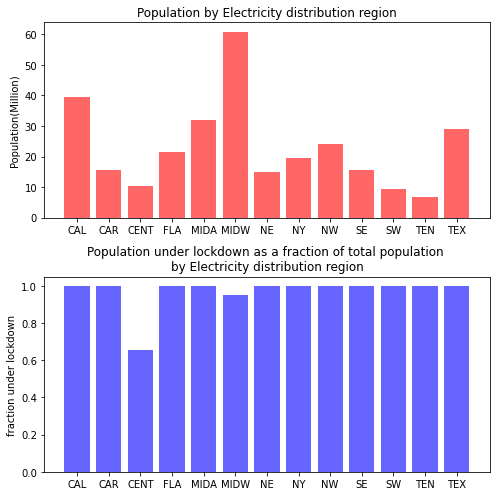

In [19]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(7,7)
ax[0].bar(pop_region.keys(), pop_region.values(), color = 'red', alpha = 0.6)
ax[0].set_ylabel('Population(Million)')
ax[0].set_title('Population by Electricity distribution region')

ax[1].bar(pop_ratio.keys(), pop_ratio.values(), color = 'blue', alpha = 0.6)
ax[1].set_ylabel('fraction under lockdown')
ax[1].set_title('Population under lockdown as a fraction of total population \nby Electricity distribution region')
plt.tight_layout()
plt.show()
                

In [6]:
states_in_region['NW']

['CO', 'ID', 'MT', 'NV', 'OR', 'WA', 'WY']

In [7]:
def generate_weights(region):
    #Helper function
    """Given a region, generates a dict where key is state name 
    and value is population as a fraction of the regions population"""
    states = states_in_region[region]
    weights = {}
    for state in states:
        weights[state] = df_states.loc[state].Population/(1e6*pop_region[region])
    return weights


In [8]:
generate_weights('NE')

{'CT': 0.24016651192386318,
 'ME': 0.09054943047395622,
 'MA': 0.464295975032238,
 'NH': 0.09159348128061161,
 'RI': 0.0713611656616075,
 'VT': 0.042033435627723506}

In [20]:
def weighted_temperature(region):
    
    """Takes all the states in the region and generates a population weighted temperature for the region.
    The output frame contains index : DATE
    columns : T_(statename), T_WA"""
    
    df_list = []
    states = states_in_region[region]
    weights = generate_weights(region)
    for state in states:
        filepath_15to19 = f"{DATA_DIR}" + "/" + state + "_2015-2019_raw.csv"
        filepath_2020 = f"{DATA_DIR}" + "/" + state + "_2020_raw.csv"
        T_train = pd.read_csv(filepath_15to19, index_col = 'DATE', parse_dates = True) #2015-2019 data
        T_test = pd.read_csv(filepath_2020, index_col = 'DATE', parse_dates = True) #2020 data
        T_all = T_train.append(T_test) # 2015-2020 data
        T_all.dropna(inplace = True) #dropping some missing entries
        T_all.rename(columns = {'MEAN_T': f'{state}'}, inplace = True)
        df_list.append(T_all)
    try:
        df = pd.concat(df_list, axis = 1)
    
        def weighted_average(row):
            wm = 0
            for col in row.index:
                wm += row[col]*weights[col]
            return wm

        df['T_WA'] = df.apply(weighted_average, axis = 1)
        df.dropna(inplace = True)
        df.to_csv(f'{DATA_DIR}' + "/" + f' Regional_{region}_2015-2020.csv')
        return df
    except ValueError:
        print(f'Problem in {region}')
        for frame in df_list:
            print(f'{frame.shape}')
        


In [10]:
weighted_temperature('NE').sample(15)

,CT,ME,MA,NH,RI,VT,T_WA
DATE,,,,,,,
2019-04-16,55.000000,40.600000,55.000000,50.00,56.0,48.000000,53.015248
2016-08-12,83.500000,75.555556,82.000000,81.50,82.5,79.000000,81.640493
2015-06-01,66.000000,57.125000,60.500000,58.25,66.0,58.166667,61.603635
2015-05-26,69.500000,65.625000,67.333333,65.25,65.0,65.333333,67.257609
2017-03-30,46.333333,32.333333,37.000000,37.00,45.0,35.857143,39.341841
2019-07-04,78.000000,68.400000,76.500000,73.00,77.0,72.571429,75.676771
2017-06-09,59.666667,68.666667,61.000000,62.00,57.5,63.428571,61.317901
2020-01-17,38.500000,22.333333,33.500000,27.50,39.0,24.142857,33.139310
2019-05-22,62.500000,48.200000,60.000000,59.00,63.0,53.285714,59.372199


In [21]:
# Generate all the Regional temperature files. Only need to run this once.
# for region in regions:
#     weighted_temperature(region)

In [12]:
def df_for_region(region):
    
    """
    Takes in region as input. Uses the population weighted temperature in that region to
    create dataframes with the following structure: 
    index : DATE,
    [23]columns:    [04] standardscaled temperatures to the 4th degree,
                [06] onehotencoded days of the week,
                [11] onehotencoded month,
                [01] Holiday(1 or 0)
                [01] Demand
    
    returns two dataframes df_train and df_test which are seperated by a cutoff date of 2020-01-01
    """
    
    reg_dict = {'CAL' : 'California', 'CAR':'Carolinas' ,
                'CENT': 'Central', 'FLA':'Florida',
                'MIDA': 'Mid-Atlantic', 'MIDW': 'Midwest',
                 'NE': 'New England',  'NY': 'New York',
                 'NW':'Northwest', 'SE': 'Southeast',
                 'SW':'Southwest', 'TEN': 'Tennessee',
                'TEX':'Texas'}
    
    df_tot = pd.DataFrame([])
    """creates a dataframe of the form 
    index: Date
    columns: Onehotencoded days,Onehotencoded months, t, t^2, t^3, t^4, Holidays, Demand """
    
    filepath = f'{DATA_DIR}' + "/" + f' Regional_{region}_2015-2020.csv'
    T_all = pd.read_csv(filepath,usecols = ['DATE','T_WA'], parse_dates = ['DATE'])
    T_all.set_index('DATE', inplace = True)

    T_all['DOW'] = T_all.index.dayofweek
    dummies = pd.get_dummies(T_all['DOW'], prefix ='D', drop_first =True) #encoding Day of the week
    
    T_all['Month'] = T_all.index.month
    dummies_month = pd.get_dummies(T_all['Month'],prefix ='M', drop_first =True)  #encoding Month
    
    
    
    r_avg = (T_all['T_WA']
                               .rolling(7, win_type='boxcar')
                               .mean()
                               )# rolling average of Temperature
    r_avg.dropna(inplace = True)# dropping leading and tailing nans

    
    X = r_avg.values.reshape(-1, 1) # reshaping Temperature data into a 2d np array
    scaler = StandardScaler() 
    X = scaler.fit_transform(X)# fitting and scaling temperature data
    
    deg = 4 #Degree of features to be generated i.e T, T^2, T^3 ...T^deg
    
    poly = PolynomialFeatures(deg, include_bias = False) #Generates Polynomial terms
    Poly4_all= pd.DataFrame(poly.fit_transform(X),
                            index = r_avg.index, 
                            columns = [f'T{i}' for i in range(deg)]) #Generates Polynomial terms
    
    Poly4_all= Poly4_all.merge(dummies, on = 'DATE', how = 'left') # adding day of week cols to frame
    Poly4_all= Poly4_all.merge(dummies_month, on = 'DATE', how = 'left') # adding month cols to frame
    
    def isholiday(row):
        # local helper function
        """returns 1 if the date is a holiday, 0 otherwise"""
        us_holidays = holidays.US()
        s = row.name.strftime('%Y-%m-%d')
        if s in us_holidays:
            return 1
        else:
            return 0
    Poly4_all['Holiday'] = Poly4_all.apply(isholiday, axis = 1) # Adding Holidays feature. 1 if holiday, 0 otherwise
    
    #add more features here later if required
    
    energy_all = read_region(reg_dict[region]) # reading energy data for state
    rolling_mean_demand = (energy_all
                                    .groupby(level=0)['Demand']
                                    .sum(min_count =24)
                                    .rolling(7, win_type='boxcar')
                                    .mean()) # rolling mean of energy demand
    
    rolling_mean_demand.dropna(inplace =True) # dropping leading and tailing nans
    
    Poly4_all = Poly4_all.merge(rolling_mean_demand.to_frame(),
                                left_index = True, right_index = True, how = 'inner') # Adding demand col to frame
    
    
    date_last = pd.to_datetime('2020-01-01') # this date is the boundary between the training and testing set
    
    df_train = Poly4_all[Poly4_all.index < date_last] # Training set
    df_test = Poly4_all[Poly4_all.index >= date_last] # Testing set
    
    return df_train, df_test


In [13]:
def plot_model_region(region):
    
    """
    Takes in region name as input. 
    Generates the training and testing dataset for that region.
    Fits a Ridge regression model to the training set and outputs a plot of the predicted data overlaid on the 
    training data. 
    Also performs a separate train-test-split on the training set in order to gauge model fit."""

    df_train, df_test = df_for_region(region) 

    
    X_train = df_train[df_train.columns[:-1]].values #training features
    y_train = df_train[df_train.columns[-1]].values #training data
    X_test = df_test[df_test.columns[:-1]].values #testing features
    y_test = df_test[df_test.columns[-1]].values #testing data
    
    model = Ridge(alpha = 1e-5) # Ridge regression model with L2 regularization
    model.fit(X_train,y_train) # fitting model on training data
    print(f'Score for 2020 data: {model.score(X_test, y_test)}')
    
    #Train-test-split on data till 2020 for judging model performance. This doesn't get used for actual testing.
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.25)
    model_tr = Ridge(alpha = 1e-5)
    model_tr.fit(X_tr,y_tr)  
    print(f'Score for model till 2019: {model.score(X_ts, y_ts)}')
    #####
    
    y_pred_train = model.predict(X_train) # predictions of our model for training data
    y_pred_test = model.predict(X_test) # predictions of our model for testing data
    
    
    #Plotting results

    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]})
    fig.set_size_inches(15,5)

    ax[0].plot(df_train.index, y_pred_train/1e3, 'r-', lw =2, label = 'Model')
    ax[0].plot(df_train.index, y_train/1e3, 'k-', lw =2, alpha = 0.7, label = 'Actual')
    
    ax[0].plot(df_test.index, y_pred_test/1e3, 'g-', lw =2, label = 'Model')
    ax[0].plot(df_test.index, y_test/1e3, 'k-', lw =2, alpha = 0.7, label = 'Actual')
    
    ax[1].plot(df_test.index, y_pred_test/1e3, 'g-', lw =2, label = 'Model')
    ax[1].plot(df_test.index, y_test/1e3, 'k-', lw =2, alpha = 0.7, label = 'Actual')
    
    
#     states = states_in_region[region]
#     for state in states:
#         ax[1].axvline(x = df_states.loc[state].LD, color = 'b', linestyle='dashed')
#         ax[1].text(df_states.loc[state].LD, ax[1].get_ylim()[1],
#                    'Lockdown', color = 'b', rotation = 270, horizontalalignment='left',
#                    verticalalignment='top')
    
    for a in ax:
        a.legend()
        a.set_ylabel('Demand(GWH)')
    
    ax[0].set_title(f'Electricity demand: expectation vs reality in {region}')
    ax[1].set_title('2020 only')
    xticklabels = df_test.index.astype('str')
    ax[1].set_xticklabels(xticklabels[: :7], rotation = 45)
    plt.tight_layout()
    plt.show()
    # plotting completed

Score for 2020 data: 0.7243789752710956
Score for model till 2019: 0.9438077290112125


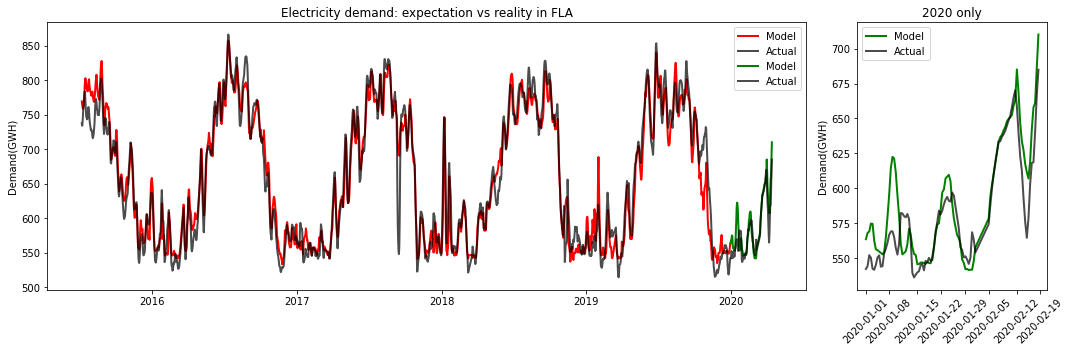

Could not process MIDA 

Could not process MIDW 

Score for 2020 data: 0.3194645239407111
Score for model till 2019: 0.8875860389159009


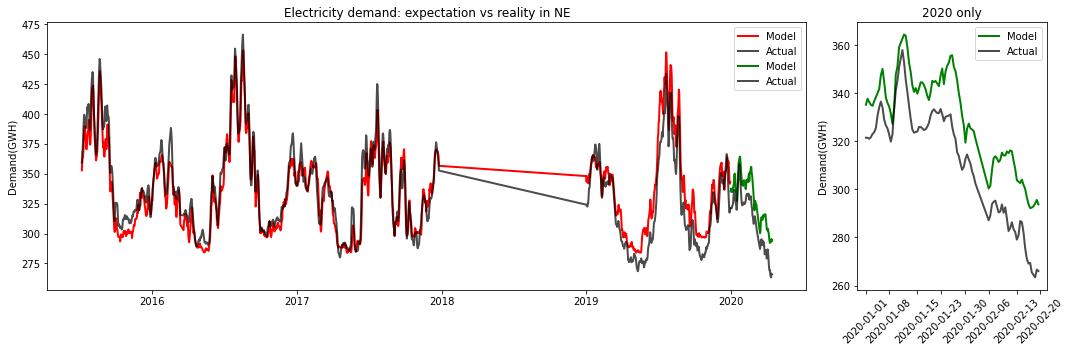

Score for 2020 data: 0.52027636295305
Score for model till 2019: 0.9604140340684668


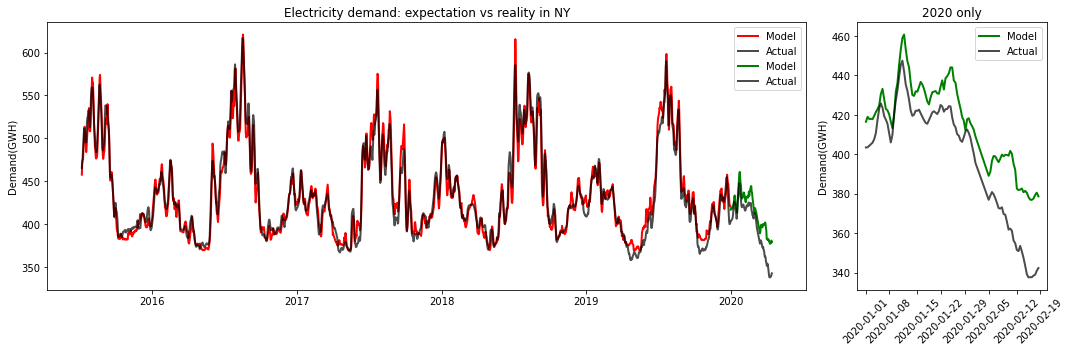

Score for 2020 data: 0.928868006601519
Score for model till 2019: 0.8531448845682018


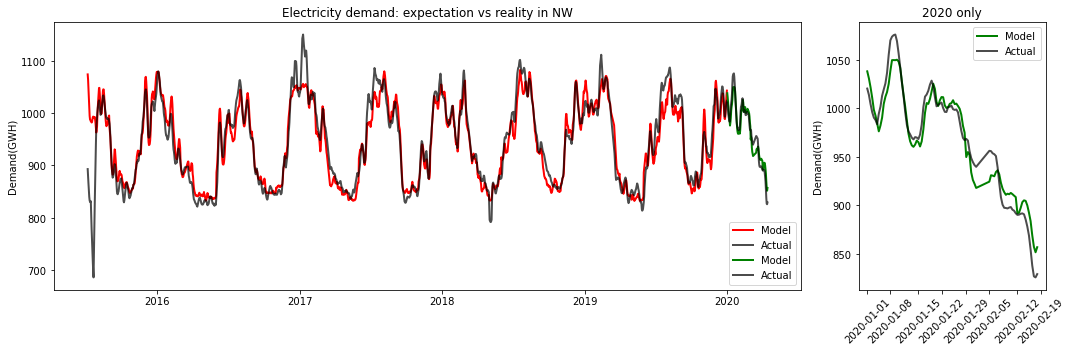

Score for 2020 data: 0.7391005026133076
Score for model till 2019: 0.3694157274438954


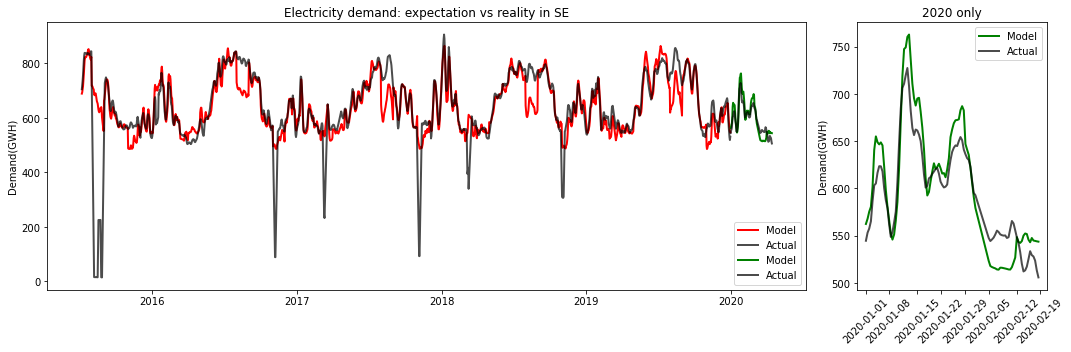

Score for 2020 data: 0.4574872757733019
Score for model till 2019: 0.9115268488078587


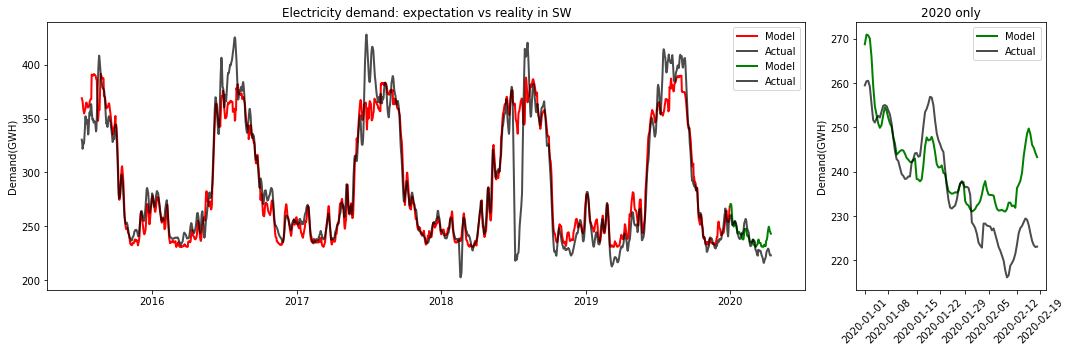

Score for 2020 data: 0.9156324218686558
Score for model till 2019: 0.9517204138308438


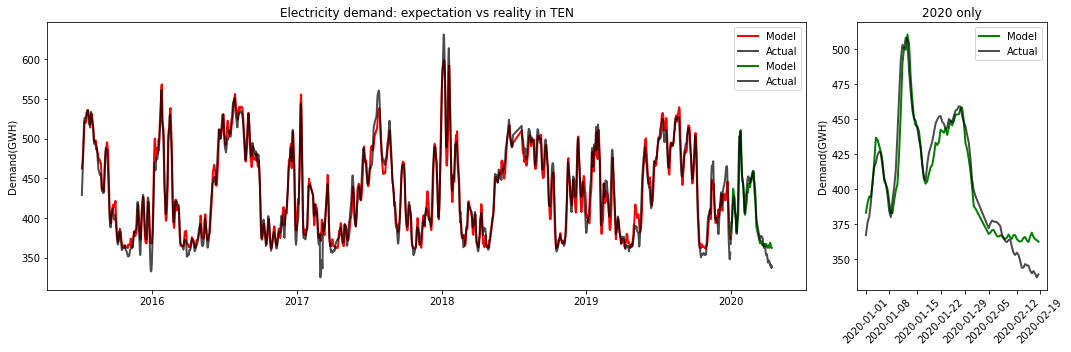

Score for 2020 data: -4.460965490417267
Score for model till 2019: 0.9447541120590449


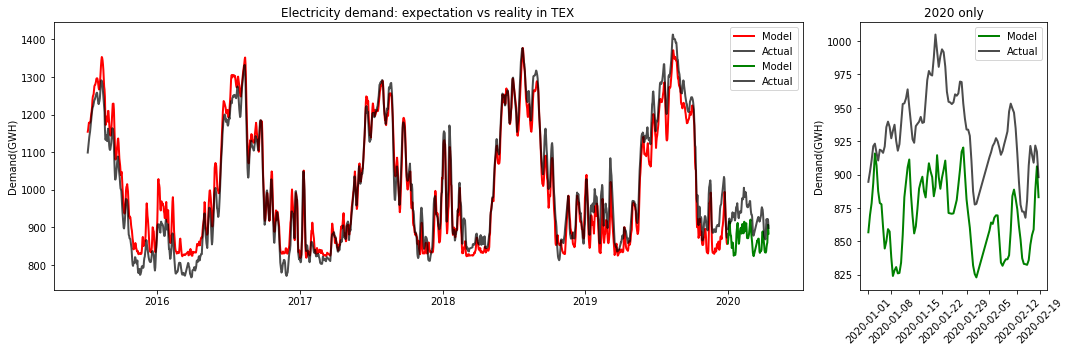

In [15]:
for region in regions[3:]:
    try:
        plot_model_region(region)
    except ValueError:
        print(f"Could not process {region} \n")

NOTE: There are problems plotting MIDA, MIDW and CAR